In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0  # Added for transfer learning
import os
import cv2
import numpy as np
import shutil
from PIL import Image
from collections import defaultdict
import hashlib
from collections import Counter

2025-07-23 05:20:39.456789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753248039.671681      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753248039.739866      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


**IMAGE PREPROCESSING**
*1.1 Crop distribution*

In [3]:
# Dataset analysis
DATASET_DIR = "/kaggle/input/crop-disease-dataset/disease/train"
class_counts = {}
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)

print("----------------------Class Distribution:--------------------------\n")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Total images and classes calculation
total_images = sum(class_counts.values())
n_classes = len(class_counts)
print(f"\n----------------------------------Dataset Summary:-----------------------")
print(f"Total images: {total_images}")
print(f"Number of classes: {n_classes}")
print(f"Average images per class: {total_images/n_classes:.1f}")


----------------------Class Distribution:--------------------------

Tomato___Late_blight: 1851 images
Tomato___healthy: 1926 images
Potato___healthy: 1824 images
Corn_(maize)___Northern_Leaf_Blight: 1908 images
Tomato___Early_blight: 1920 images
Tomato___Septoria_leaf_spot: 1745 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
Apple___Apple_scab: 2016 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 images
Tomato___Bacterial_spot: 1702 images
Apple___Black_rot: 2027 images
Apple___Cedar_apple_rust: 1760 images
Tomato___Target_Spot: 1827 images
Pepper,_bell___healthy: 1988 images
Potato___Late_blight: 1939 images
Tomato___Tomato_mosaic_virus: 1790 images
Apple___healthy: 2008 images
Potato___Early_blight: 1939 images
Corn_(maize)___Common_rust_: 1948 images
Tomato___Leaf_Mold: 1882 images
Tomato___Spider_mites Two-spotted_spider_mite: 1741 images
Pepper,_bell___Bacterial_spot: 1913 images
Corn_(maize)___healthy: 1859 images

----------------------------------Da

In [4]:
# Find min and max class sizes
min_images = min(class_counts.values())
max_images = max(class_counts.values())
min_class_name = min(class_counts, key=class_counts.get)
max_class_name = max(class_counts, key=class_counts.get)
print(f"Smallest class \n{min_class_name}=> {min_images} images\n")
print(f"Largest class \n{max_class_name}=> {max_images} images\n")


Smallest class 
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot=> 1642 images

Largest class 
Apple___Black_rot=> 2027 images



*Check for duplicates*

In [5]:
print("-------------------Counting images in each class----------------------------------")
image_extensions=('.jpg', '.jpeg', '.png')      
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) 
        if f.lower().endswith(image_extensions)]
        class_counts[class_name] = len(images)
print(class_counts)

-------------------Counting images in each class----------------------------------
{'Tomato___Late_blight': 1851, 'Tomato___healthy': 1926, 'Potato___healthy': 1824, 'Corn_(maize)___Northern_Leaf_Blight': 1908, 'Tomato___Early_blight': 1920, 'Tomato___Septoria_leaf_spot': 1745, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1642, 'Apple___Apple_scab': 2016, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1961, 'Tomato___Bacterial_spot': 1702, 'Apple___Black_rot': 2027, 'Apple___Cedar_apple_rust': 1760, 'Tomato___Target_Spot': 1827, 'Pepper,_bell___healthy': 1988, 'Potato___Late_blight': 1939, 'Tomato___Tomato_mosaic_virus': 1790, 'Apple___healthy': 2008, 'Potato___Early_blight': 1939, 'Corn_(maize)___Common_rust_': 1948, 'Tomato___Leaf_Mold': 1882, 'Tomato___Spider_mites Two-spotted_spider_mite': 1741, 'Pepper,_bell___Bacterial_spot': 1913, 'Corn_(maize)___healthy': 1859}


In [6]:
# Dataset balance analysis
if class_counts: 
    counts = list(class_counts.values())
    total_images = sum(counts)
    n_classes = len(class_counts)
    
    analysis_results = {
        'total_images': total_images,
        'n_classes': n_classes,
        'average_per_class': total_images / n_classes,
        'min_images': min(counts),
        'max_images': max(counts),
        'std_dev': np.std(counts),
        'median': np.median(counts)
    }
    
    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)
    
    analysis_results['min_class'] = min_class
    analysis_results['max_class'] = max_class
    
    imbalance_ratio = analysis_results['max_images'] / analysis_results['min_images']
    analysis_results['imbalance_ratio'] = imbalance_ratio
    
    if imbalance_ratio < 2:
        balance_status = "Well Balanced"
    elif imbalance_ratio < 5:
        balance_status = "Slightly Imbalanced"
    elif imbalance_ratio < 10:
        balance_status = "Moderately Imbalanced"
    else:
        balance_status = "Severely Imbalanced"
    
    analysis_results['balance_status'] = balance_status
    
    print("--------------Analysis results------------------")
    print(analysis_results)
else:
    print("No classes found in the dataset!")


--------------Analysis results------------------
{'total_images': 43116, 'n_classes': 23, 'average_per_class': 1874.608695652174, 'min_images': 1642, 'max_images': 2027, 'std_dev': 103.59315871755861, 'median': 1908.0, 'min_class': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'max_class': 'Apple___Black_rot', 'imbalance_ratio': 1.2344701583434836, 'balance_status': 'Well Balanced'}


**Visualisations**

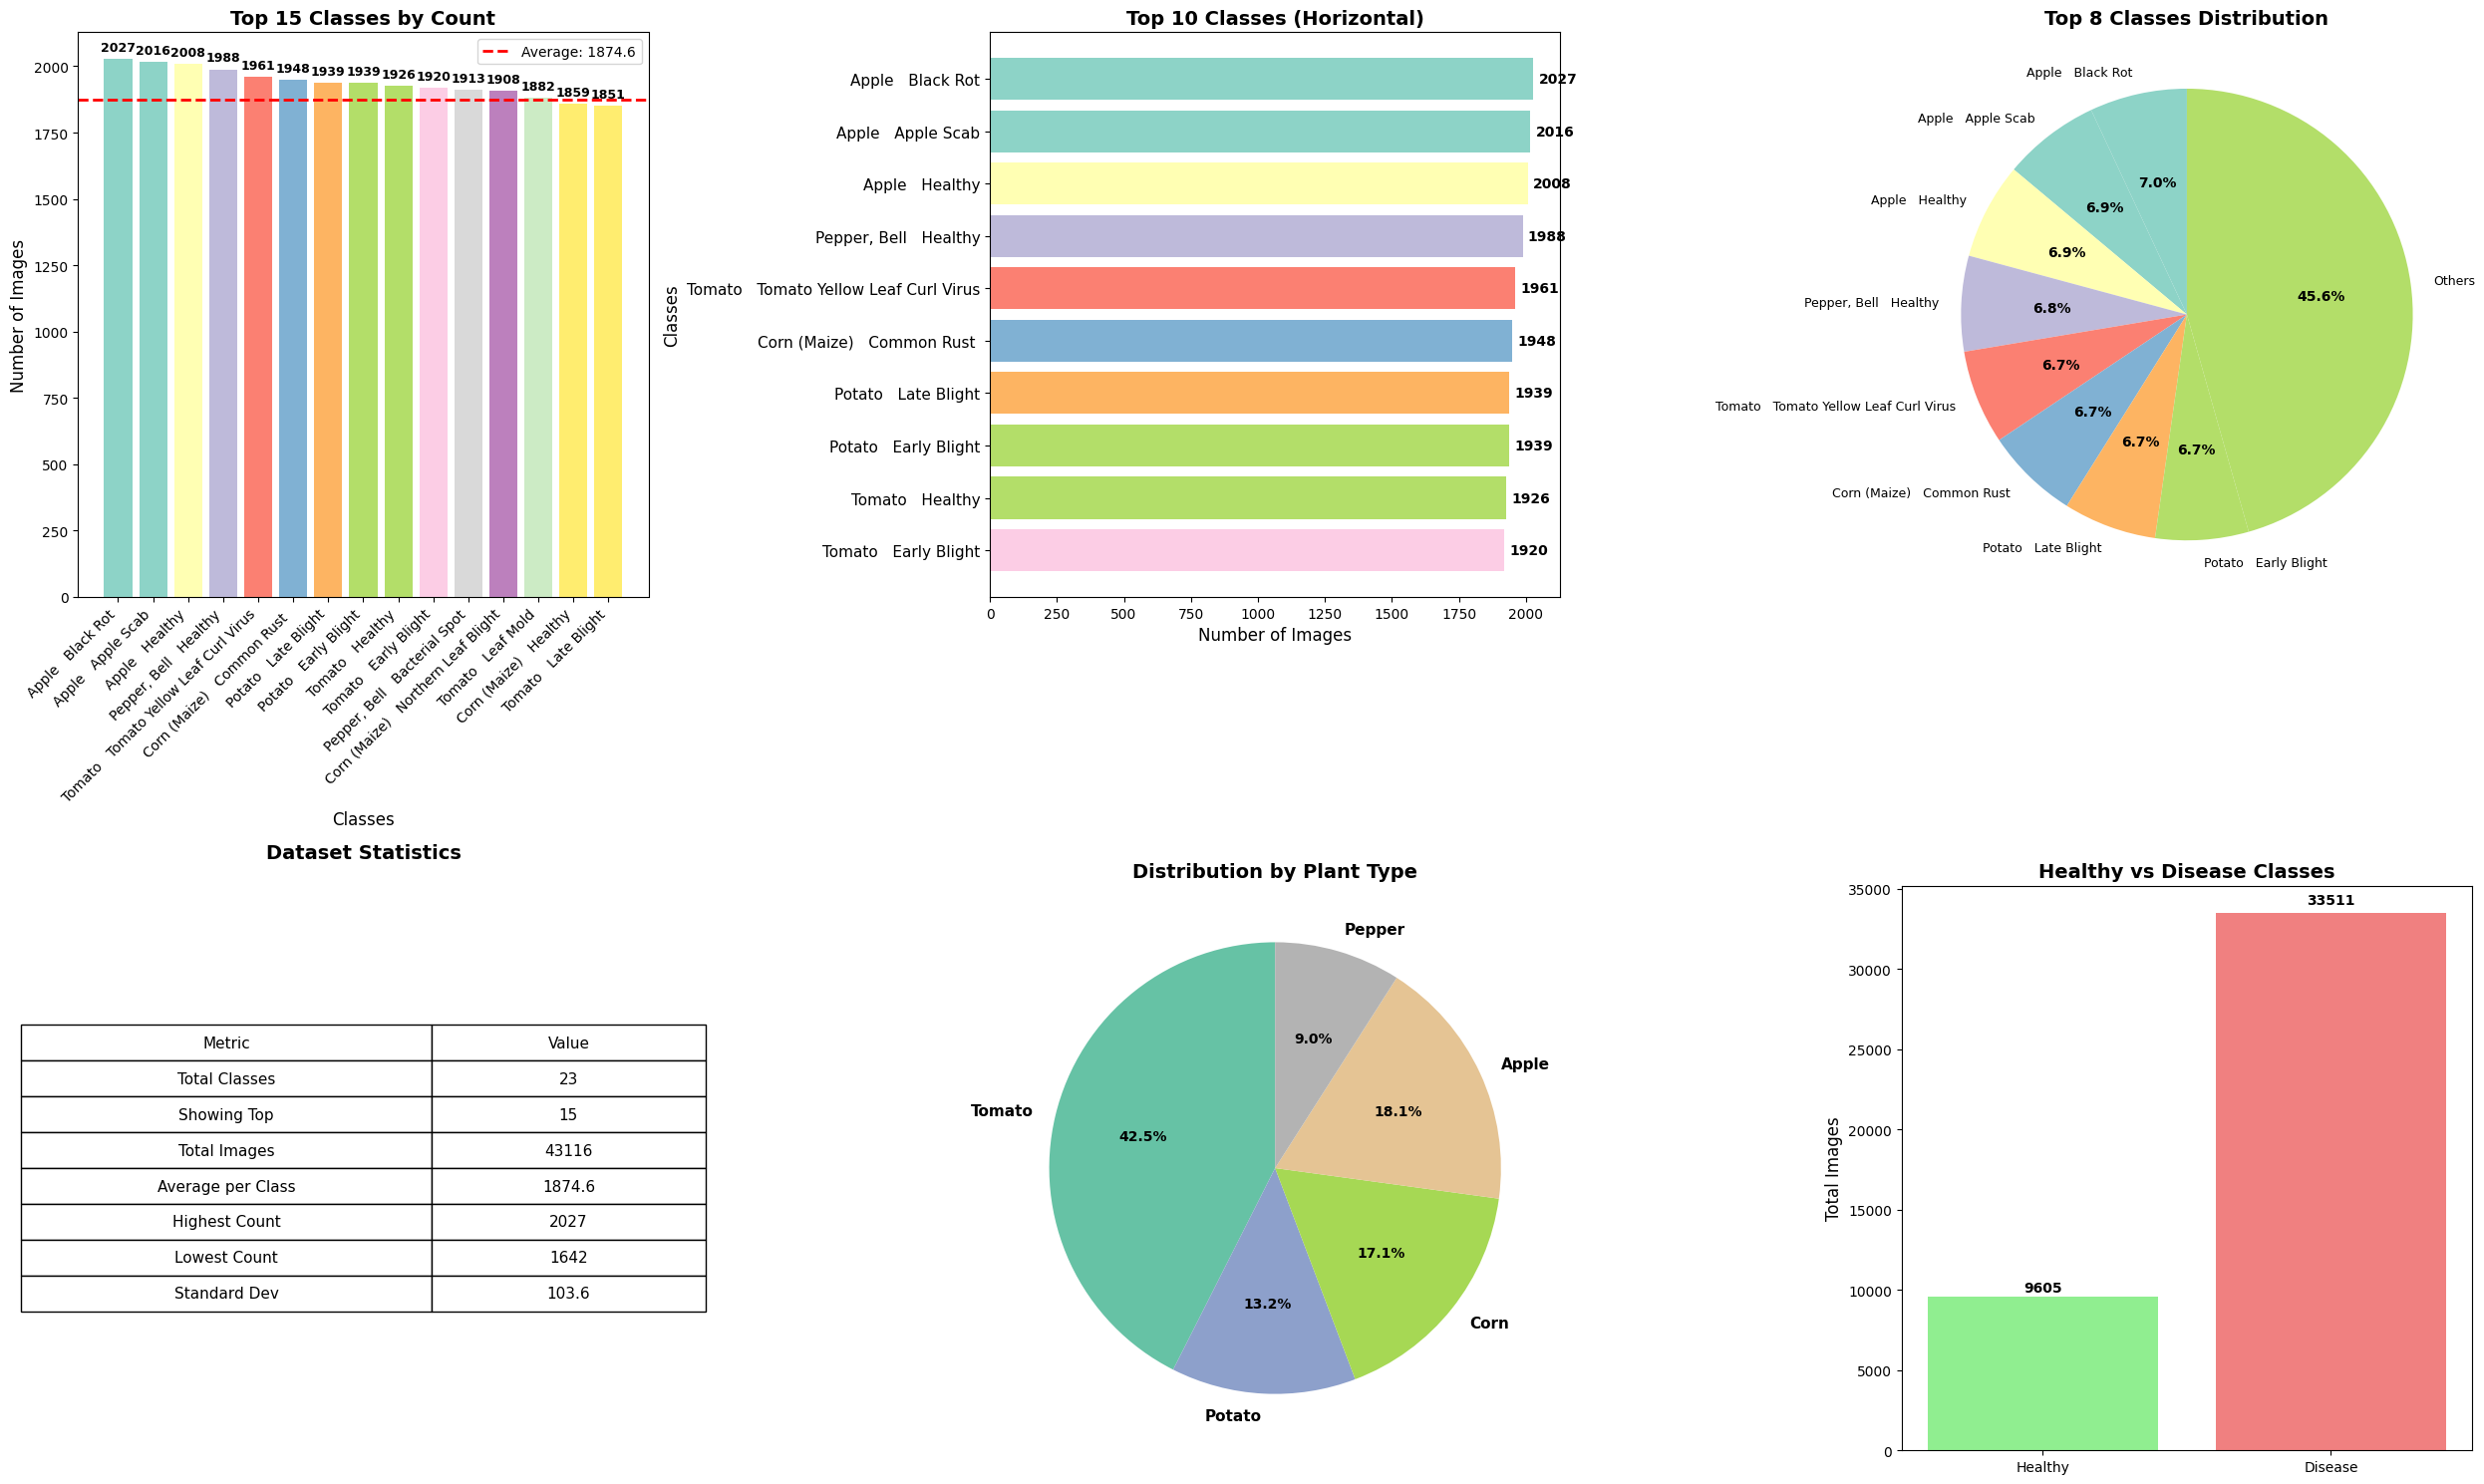

In [7]:
#figure with multiple subplots
fig = plt.figure(figsize=(25, 15))

# Sort classes by count for better visualization(SHOW ONLY TOP 15)
sorted_classes = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:15])
class_names = list(sorted_classes.keys())
class_values = list(sorted_classes.values())

# Clean up class names(better readability)
clean_class_names = [name.replace('_', ' ').title() for name in class_names]

# Color scheme
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

# Main bar plot - sorted by count (TOP 15 ONLY)
ax1 = plt.subplot(2, 3, 1)
bars1 = ax1.bar(range(len(class_names)), class_values, color=colors)
ax1.set_title('Top 15 Classes by Count', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classes', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_xticks(range(len(class_names)))
ax1.set_xticklabels(clean_class_names, rotation=45, ha='right', fontsize=10)

# value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
    f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

#average line
avg_line = analysis_results['average_per_class']
ax1.axhline(y=avg_line, color='red', linestyle='--', linewidth=2, 
            label=f'Average: {avg_line:.1f}')
ax1.legend()

# Horizontal bar plot(TOP 10 ONLY)
ax2 = plt.subplot(2, 3, 2)
top_10_names = class_names[:10]
top_10_values = class_values[:10]
top_10_clean = clean_class_names[:10]

bars2 = ax2.barh(range(len(top_10_names)), top_10_values, color=colors[:10])
ax2.set_title('Top 10 Classes (Horizontal)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Images', fontsize=12)
ax2.set_ylabel('Classes', fontsize=12)
ax2.set_yticks(range(len(top_10_names)))
ax2.set_yticklabels(top_10_clean, fontsize=11)
ax2.invert_yaxis()  # Highest count at top

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
            f'{int(width)}', ha='left', va='center', fontweight='bold', fontsize=10)

# Pie chart (TOP 8 ONLY )
ax3 = plt.subplot(2, 3, 3)
top_8_names = clean_class_names[:8]
top_8_values = class_values[:8]
other_sum = sum(class_values[8:])

if other_sum > 0:
    pie_names = top_8_names + ['Others']
    pie_values = top_8_values + [other_sum]
else:
    pie_names = top_8_names
    pie_values = top_8_values

wedges, texts, autotexts = ax3.pie(pie_values, labels=pie_names, autopct='%1.1f%%',
                                   colors=colors[:len(pie_values)], startangle=90)
ax3.set_title('Top 8 Classes Distribution', fontsize=14, fontweight='bold')

# Make percentage text bold and adjust font size
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Adjust label font size
for text in texts:
    text.set_fontsize(9)

# Statistics summary
ax4 = plt.subplot(2, 3, 4)
ax4.axis('off')

# Create a clean statistics table
stats_data = [
    ['Total Classes', len(class_counts)],
    ['Showing Top', len(class_names)],
    ['Total Images', sum(class_counts.values())],
    ['Average per Class', f'{analysis_results["average_per_class"]:.1f}'],
    ['Highest Count', max(class_counts.values())],
    ['Lowest Count', min(class_counts.values())],
    ['Standard Dev', f'{analysis_results.get("std_dev", 0):.1f}']
]

table = ax4.table(cellText=stats_data,
                  colLabels=['Metric', 'Value'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

ax4.set_title('Dataset Statistics', fontsize=14, fontweight='bold', pad=20)

# Plant type grouping (if applicable)
ax5 = plt.subplot(2, 3, 5)
plant_groups = {}
for class_name, count in class_counts.items():
    if any(word in class_name.lower() for word in ['apple']):
        plant_type = 'Apple'
    elif any(word in class_name.lower() for word in ['tomato']):
        plant_type = 'Tomato'
    elif any(word in class_name.lower() for word in ['corn']):
        plant_type = 'Corn'
    elif any(word in class_name.lower() for word in ['potato']):
        plant_type = 'Potato'
    elif any(word in class_name.lower() for word in ['pepper']):
        plant_type = 'Pepper'
    else:
        plant_type = 'Other'
    
    if plant_type not in plant_groups:
        plant_groups[plant_type] = 0
    plant_groups[plant_type] += count

if len(plant_groups) > 1:
    wedges2, texts2, autotexts2 = ax5.pie(plant_groups.values(), 
                                          labels=plant_groups.keys(), 
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          colors=plt.cm.Set2(np.linspace(0, 1, len(plant_groups))))
    ax5.set_title('Distribution by Plant Type', fontsize=14, fontweight='bold')
    
    for text in texts2:
        text.set_fontsize(11)
        text.set_fontweight('bold')
    for autotext in autotexts2:
        autotext.set_fontsize(10)
        autotext.set_fontweight('bold')
else:
    ax5.text(0.5, 0.5, 'Single Plant Type\nDataset', ha='center', va='center', 
             fontsize=14, fontweight='bold', transform=ax5.transAxes)
    ax5.set_title('Plant Type Analysis', fontsize=14, fontweight='bold')

# Balance analysis
ax6 = plt.subplot(2, 3, 6)
healthy_count = sum(count for class_name, count in class_counts.items() 
                   if 'healthy' in class_name.lower())
disease_count = sum(count for class_name, count in class_counts.items() 
                   if 'healthy' not in class_name.lower())

if healthy_count > 0 and disease_count > 0:
    categories = ['Healthy', 'Disease']
    counts = [healthy_count, disease_count]
    colors_balance = ['lightgreen', 'lightcoral']
    
    bars6 = ax6.bar(categories, counts, color=colors_balance)
    ax6.set_title('Healthy vs Disease Classes', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Total Images', fontsize=12)
    
    for i, bar in enumerate(bars6):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No Healthy/Disease\nClassification Available', 
             ha='center', va='center', fontsize=12, fontweight='bold', 
             transform=ax6.transAxes)
    ax6.set_title('Class Balance Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
EPOCHS = 15 
BATCH_SIZE = 64 
IMG_SIZE = 224 
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001 

In [9]:
# Check validation directory
valid_dir = "/kaggle/input/crop-disease-dataset/disease/valid"
all_valid_classes = os.listdir(valid_dir)
print(f"All validation classes ({len(all_valid_classes)}):")
for i, cls in enumerate(all_valid_classes):
    print(f"{i+1}. {cls}")

# Define classes to keep
classes_to_keep = [
    'Tomato___Late_blight', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Corn_(maize)___Common_rust_',
    'Potato___Early_blight', 'Apple___healthy', 'Tomato___Tomato_mosaic_virus', 'Potato___Late_blight',
    'Pepper,_bell___healthy', 'Tomato___Target_Spot', 'Apple___Cedar_apple_rust', 'Apple___Black_rot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Apple_scab',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Septoria_leaf_spot',
    'Tomato___Early_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___healthy', 'Tomato___healthy'
]

print(len(classes_to_keep))

All validation classes (38):
1. Tomato___Late_blight
2. Tomato___healthy
3. Grape___healthy
4. Orange___Haunglongbing_(Citrus_greening)
5. Soybean___healthy
6. Squash___Powdery_mildew
7. Potato___healthy
8. Corn_(maize)___Northern_Leaf_Blight
9. Tomato___Early_blight
10. Tomato___Septoria_leaf_spot
11. Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
12. Strawberry___Leaf_scorch
13. Peach___healthy
14. Apple___Apple_scab
15. Tomato___Tomato_Yellow_Leaf_Curl_Virus
16. Tomato___Bacterial_spot
17. Apple___Black_rot
18. Blueberry___healthy
19. Cherry_(including_sour)___Powdery_mildew
20. Peach___Bacterial_spot
21. Apple___Cedar_apple_rust
22. Tomato___Target_Spot
23. Pepper,_bell___healthy
24. Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
25. Potato___Late_blight
26. Tomato___Tomato_mosaic_virus
27. Strawberry___healthy
28. Apple___healthy
29. Grape___Black_rot
30. Potato___Early_blight
31. Cherry_(including_sour)___healthy
32. Corn_(maize)___Common_rust_
33. Grape___Esca_(Black_Measles)
34

In [10]:
crop_classes = len(classes_to_keep)
print(f"Number of classes to train on: {crop_classes}")

Number of classes to train on: 23


In [11]:

# Data augmentation setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Creating data generators...")

# Training generator
train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/crop-disease-dataset/disease/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = val_test_datagen.flow_from_directory(
    "/kaggle/input/crop-disease-dataset/disease/valid",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep, 
    class_mode='categorical',
    shuffle=False
)

# Test generator 
test_generator = val_test_datagen.flow_from_directory(
    "/kaggle/input/crop-disease-dataset/disease/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=classes_to_keep, 
    class_mode='categorical',
)

Creating data generators...
Found 43116 images belonging to 23 classes.
Found 10758 images belonging to 23 classes.
Found 0 images belonging to 23 classes.


In [12]:
print(len('/kaggle/input/crop-disease-dataset/disease/valid'))

48


In [13]:
# Model building with distributed strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")


Number of devices: 2


I0000 00:00:1753248078.648747      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753248078.649555      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
# Get number of classes
crop_classes = len(train_generator.class_indices)
print(f"Number of classes: {crop_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 23
Class indices: {'Tomato___Late_blight': 0, 'Corn_(maize)___healthy': 1, 'Pepper,_bell___Bacterial_spot': 2, 'Tomato___Spider_mites Two-spotted_spider_mite': 3, 'Tomato___Leaf_Mold': 4, 'Corn_(maize)___Common_rust_': 5, 'Potato___Early_blight': 6, 'Apple___healthy': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Potato___Late_blight': 9, 'Pepper,_bell___healthy': 10, 'Tomato___Target_Spot': 11, 'Apple___Cedar_apple_rust': 12, 'Apple___Black_rot': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Bacterial_spot': 15, 'Apple___Apple_scab': 16, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 17, 'Tomato___Septoria_leaf_spot': 18, 'Tomato___Early_blight': 19, 'Corn_(maize)___Northern_Leaf_Blight': 20, 'Potato___healthy': 21, 'Tomato___healthy': 22}


In [15]:
def create_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Head
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(len(classes_to_keep), activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,039 (1.76 MB)

 Trainable params: 461,079 (1.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
#call backs
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,  # Increased from 3
        min_delta=0.001,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

In [17]:
#compile the model
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
#steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print('-------------------------------------------')
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {validation_steps}")

-------------------------------------------
Training samples: 43116
Validation samples: 10758
Training steps per epoch: 673
Validation steps per epoch: 168


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

print("Computing class weights...")

if 'class_counts' in locals() and class_counts:
    # Use the class_counts you already computed
    print("Using existing class_counts dictionary...")
    
    # Create labels array based on class counts
    labels = []
    class_to_index = {}
    
    for i, class_name in enumerate(classes_to_keep):
        if class_name in class_counts:
            class_to_index[class_name] = i
            # Add label index repeated by count of images in that class
            labels.extend([i] * class_counts[class_name])
        else:
            print(f"Warning: {class_name} not found in class_counts")
    
    print(f"Total labels created: {len(labels)}")
    print(f"Class to index mapping: {class_to_index}")
    
else:
    print("Computing class counts from directory...")
    
    train_dir = "/kaggle/input/crop-disease-dataset/disease/train"
    class_to_index = {}
    labels = []
    
    for i, class_name in enumerate(classes_to_keep):
        class_folder = os.path.join(train_dir, class_name)
        if os.path.exists(class_folder):
            # Count images in this class folder
            image_files = [f for f in os.listdir(class_folder) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            count = len(image_files)
            
            class_to_index[class_name] = i
            labels.extend([i] * count)
            print(f"Class {class_name} (index {i}): {count} images")
        else:
            print(f"Warning: Directory {class_folder} not found!")

# Compute class weights using sklearn
unique_classes = np.unique(labels)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=labels
)

# Convert to dictionary format that Keras expects
class_weights_dict = {}
for i, weight in enumerate(class_weights_array):
    class_weights_dict[i] = weight

print("\nClass weights (dictionary format):")
for class_idx, weight in class_weights_dict.items():
    class_name = classes_to_keep[class_idx] if class_idx < len(classes_to_keep) else f"Class_{class_idx}"
    print(f"  {class_name}: {weight:.4f}")

print(f"\nClass weights type: {type(class_weights_dict)}")
print(f"Class weights keys: {list(class_weights_dict.keys())}")

# Verify generators are working properly
print("\nVerifying data generators...")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training classes: {len(train_generator.class_indices)}")
print(f"Validation classes: {len(validation_generator.class_indices)}")

# Check if generators have the same class indices
if train_generator.class_indices == validation_generator.class_indices:
    print("✅ Train and validation generators have matching class indices")
else:
    print("⚠️  Train and validation generators have different class indices!")
    print(f"Train indices: {train_generator.class_indices}")
    print(f"Validation indices: {validation_generator.class_indices}")

# Calculate steps per epoch
train_steps = len(train_generator)
validation_steps = len(validation_generator)

print(f"\nTraining steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {validation_steps}")

#  MODEL TRAINING
print("\n" + "="*50)
print("Starting model training with corrected class weights...")
print("="*50)

try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights_dict,  # Use dictionary
        verbose=1
    )
    
    print("✅ Training completed successfully!")
    
except Exception as e:
    print(f"❌ Training failed with error: {str(e)}")
    print("\nTrying without class weights...")
    
    # Fallback: train without class weights
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    print("✅ Training completed without class weights!")

#  class weight calculation
def calculate_class_weights_manual():
    """Calculate class weights manually if sklearn approach fails"""
    
    print("\nCalculating class weights manually...")
    
    # Get class distribution from training generator
    class_distribution = {}
    
    # Method using train_generator.classes if available
    if hasattr(train_generator, 'classes') and train_generator.classes is not None:
        unique, counts = np.unique(train_generator.classes, return_counts=True)
        for class_idx, count in zip(unique, counts):
            class_distribution[class_idx] = count
    else:
        # Alternative method using directory counting
        for i, class_name in enumerate(classes_to_keep):
            class_folder = os.path.join("/kaggle/input/crop-disease-dataset/disease/train", class_name)
            if os.path.exists(class_folder):
                count = len([f for f in os.listdir(class_folder) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                class_distribution[i] = count
    
    # Calculate balanced weights
    total_samples = sum(class_distribution.values())
    n_classes = len(class_distribution)
    
    class_weights_manual = {}
    for class_idx, count in class_distribution.items():
        # Balanced weight formula: total_samples / (n_classes * class_count)
        weight = total_samples / (n_classes * count)
        class_weights_manual[class_idx] = weight
    
    print("Manual class weights:")
    for class_idx, weight in class_weights_manual.items():
        print(f"  Class {class_idx}: {weight:.4f}")
    
    return class_weights_manual

print(f"\nFinal class_weights_dict type: {type(class_weights_dict)}")
print(f"Sample of class weights: {dict(list(class_weights_dict.items())[:3])}")

Computing class weights...
Using existing class_counts dictionary...
Total labels created: 43116
Class to index mapping: {'Tomato___Late_blight': 0, 'Corn_(maize)___healthy': 1, 'Pepper,_bell___Bacterial_spot': 2, 'Tomato___Spider_mites Two-spotted_spider_mite': 3, 'Tomato___Leaf_Mold': 4, 'Corn_(maize)___Common_rust_': 5, 'Potato___Early_blight': 6, 'Apple___healthy': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Potato___Late_blight': 9, 'Pepper,_bell___healthy': 10, 'Tomato___Target_Spot': 11, 'Apple___Cedar_apple_rust': 12, 'Apple___Black_rot': 13, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14, 'Tomato___Bacterial_spot': 15, 'Apple___Apple_scab': 16, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 17, 'Tomato___Septoria_leaf_spot': 18, 'Tomato___Early_blight': 19, 'Corn_(maize)___Northern_Leaf_Blight': 20, 'Potato___healthy': 21, 'Tomato___healthy': 22}

Class weights (dictionary format):
  Tomato___Late_blight: 1.0128
  Corn_(maize)___healthy: 1.0084
  Pepper,_bell___Bacterial_spot:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1753248089.579359     118 service.cc:148] XLA service 0x7f5768216a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753248089.580128     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753248089.580150     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753248090.321904     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/674 ━━━━━━━━━━━━━━━━━━━━ 3:46:08 20s/step - accuracy: 0.0312 - loss: 6.5558

I0000 00:00:1753248102.736839     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4815 - loss: 2.9989
Epoch 1: val_accuracy improved from -inf to 0.37275, saving model to best_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - accuracy: 0.4817 - loss: 2.9973 - val_accuracy: 0.3727 - val_loss: 2.6892 - learning_rate: 0.0010
Epoch 2/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.7914 - loss: 0.8490
Epoch 2: val_accuracy improved from 0.37275 to 0.68907, saving model to best_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - accuracy: 0.7915 - loss: 0.8488 - val_accuracy: 0.6891 - val_loss: 1.2878 - learning_rate: 0.0010
Epoch 3/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.8638 - loss: 0.5972
Epoch 3: val_accuracy improved from 0.68907 to 0.82283, saving model to best_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 662s 982ms/step - accuracy: 0.8638 - loss: 0.5972 - val_accuracy: 0.8228 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 4/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy:

In [20]:
# #train the model on the training dataset on vaalidation data
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=EPOCHS,
#     validation_data=validation_generator,
#     validation_steps=len(validation_generator),
#     callbacks=callbacks,
#     class_weight=class_weights,
#     verbose=1
# )



In [21]:
# After training
model.save('/kaggle/working/crop_disease_model.h5')

In [22]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.9134 - loss: 0.3253
Test Accuracy: 0.9188
Test Loss: 0.3206


In [23]:
# After training
model.save('/kaggle/working/crop_disease_model.h5')

# Also save additional files you might need
import json
import pickle

# Save model info
model_info = {
    'accuracy': float(max(history.history['val_accuracy'])),
    'input_shape': model.input_shape,
    'output_shape': model.output_shape,
    'classes': list(train_generator.class_indices.keys()),  # if using ImageDataGenerator
    'training_date': '2024-07-14'
}

with open('/kaggle/working/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

# Save training history
with open('/kaggle/working/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Files saved to /kaggle/working/")

Files saved to /kaggle/working/


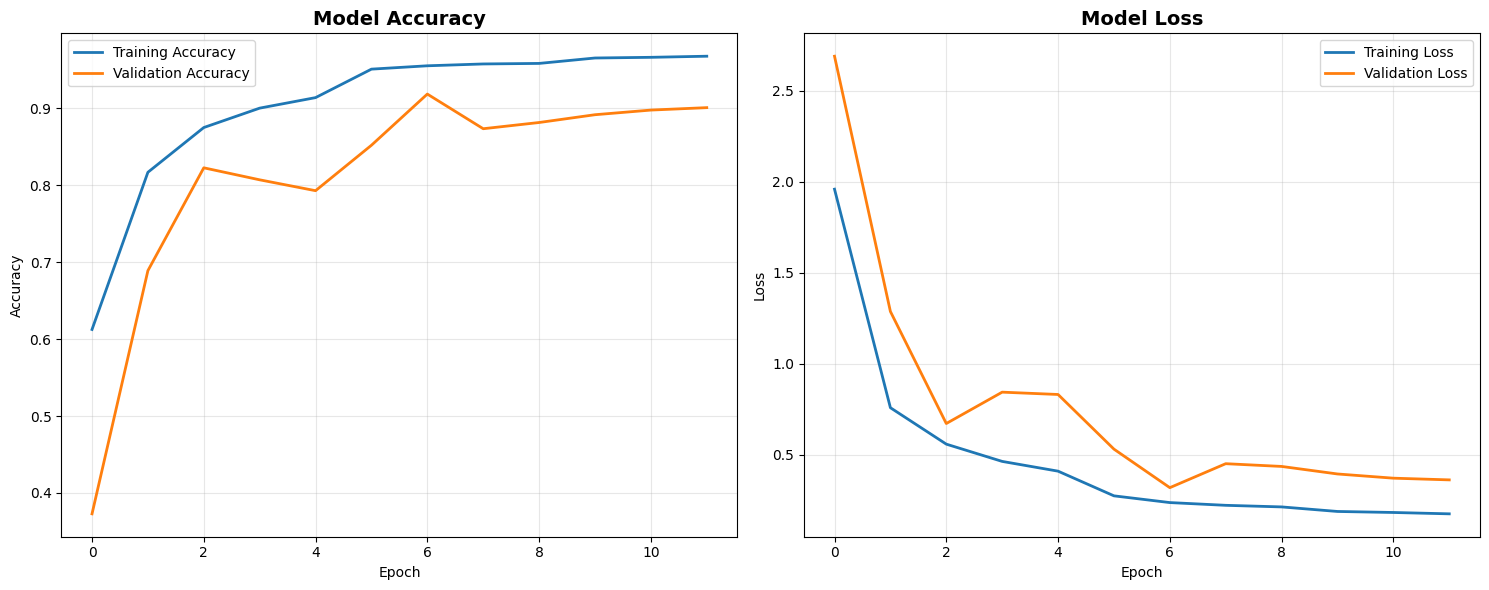

In [25]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Load best model for evaluation
model.load_weights('/kaggle/working/best_model.h5')

In [26]:
# Evaluate the model
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Final Test Loss: {test_loss:.4f}")

# Check if target accuracy is reached
if test_accuracy >= 0.96:
    print("🎉 TARGET ACCURACY ACHIEVED! Model performs at 96%+ accuracy!")
else:
    print(f"Target accuracy not yet reached. Current: {test_accuracy*100:.2f}%")
    print("Consider: More epochs, different augmentation, or model architecture adjustments")



FINAL EVALUATION
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.9134 - loss: 0.3253
Final Test Accuracy: 0.9188 (91.88%)
Final Test Loss: 0.3206
Target accuracy not yet reached. Current: 91.88%
Consider: More epochs, different augmentation, or model architecture adjustments


In [27]:
def predict_image(image_path, model, class_indices):
    try:
        # Load and preprocess image
        img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        
        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_index]
        
        # Get class name
        class_names = {v: k for k, v in class_indices.items()}
        predicted_class = class_names[predicted_class_index]
        
        return predicted_class, confidence
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, 0.0

print(f'\nTo use prediction: predict_image("/kaggle/input/crop-disease-dataset/disease/test/AppleCedarRust1.JPG", model, train_generator.class_indices)')


To use prediction: predict_image("/kaggle/input/crop-disease-dataset/disease/test/AppleCedarRust1.JPG", model, train_generator.class_indices)


In [28]:
# Add this for better evaluation
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

def evaluate_model_thoroughly(model, validation_generator):
    # Get predictions
    predictions = model.predict(validation_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    true_classes = validation_generator.classes
    
    # Generate reports
    class_names = list(validation_generator.class_indices.keys())
    
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(true_classes, predicted_classes))

In [30]:
# Install required library
!pip install pydrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and upload
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Upload model
uploaded = drive.CreateFile({'title': 'best_model.h5'})
uploaded.SetContentFile('/kaggle/working/crop_disease_model.h5')
uploaded.Upload()

print(f"Model uploaded to Google Drive with ID: {uploaded['id']}")

Model uploaded to Google Drive with ID: 1HjZQNnw4Gn8Y2wXkQe_nRekk8IVLBEMP


In [33]:
print("\n" + "="*80)
print("TRAINING ADDITIONAL MODELS - SEVERITY & PLANT PART DETECTION")
print("="*80)

# create label mappings from existing class names
def create_severity_mapping(classes):
    """Map existing disease classes to severity levels (0-3)"""
    severity_labels = []
    severity_names = ['Healthy', 'Mild', 'Moderate', 'Severe']
    
    print("Creating Severity Mapping:")
    for i, class_name in enumerate(classes):
        class_lower = class_name.lower()
        
        if 'healthy' in class_lower:
            severity = 0  # Healthy
        elif any(word in class_lower for word in ['early', 'spot', 'rust']):
            severity = 1  # Mild
        elif any(word in class_lower for word in ['bacterial', 'mold', 'scab', 'cedar']):
            severity = 2  # Moderate  
        elif any(word in class_lower for word in ['late', 'blight', 'virus', 'curl', 'mosaic']):
            severity = 3  # Severe
        else:
            severity = 2  # Default moderate
            
        severity_labels.append(severity)
        print(f"  {class_name[:45]:<45} → {severity_names[severity]}")
    
    return severity_labels, severity_names



TRAINING ADDITIONAL MODELS - SEVERITY & PLANT PART DETECTION


In [35]:

def create_plant_part_mapping(classes):
    """Map existing classes to plant parts (0-3)"""
    part_labels = []
    part_names = ['Leaf', 'Fruit', 'Corn', 'Other']
    
    print("\nCreating Plant Part Mapping:")
    for i, class_name in enumerate(classes):
        class_lower = class_name.lower()
        
        if 'tomato' in class_lower or 'apple' in class_lower:
            if 'tomato' in class_lower:
                part = 1  # Fruit (tomato)
            else:
                part = 1  # Fruit (apple)
        elif 'corn' in class_lower or 'maize' in class_lower:
            part = 2  # Corn
        elif 'pepper' in class_lower or 'potato' in class_lower:
            part = 0  # Leaf (most pepper/potato diseases affect leaves)
        else:
            part = 0  # Default to leaf
            
        part_labels.append(part)
        print(f"  {class_name[:45]:<45} → {part_names[part]}")
    
    return part_labels, part_names

# Create the mappings
severity_labels, severity_names = create_severity_mapping(classes_to_keep)
part_labels, part_names = create_plant_part_mapping(classes_to_keep)


# SEVERITY DETECTION MODEL
def create_severity_model():
    """Model specifically designed for disease severity detection"""
    print("\n--- BUILDING SEVERITY DETECTION MODEL ---")
    
    model = Sequential([
        # Input layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        # Feature extraction - optimized for severity patterns
        Conv2D(64, (5, 5), activation='relu'),  # Larger kernel for severity patterns
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Deep feature extraction for severity nuances
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Global pooling and classification
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(4, activation='softmax', name='severity_output')  # 4 severity levels
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


Creating Severity Mapping:
  Tomato___Late_blight                          → Severe
  Corn_(maize)___healthy                        → Healthy
  Pepper,_bell___Bacterial_spot                 → Mild
  Tomato___Spider_mites Two-spotted_spider_mite → Mild
  Tomato___Leaf_Mold                            → Moderate
  Corn_(maize)___Common_rust_                   → Mild
  Potato___Early_blight                         → Mild
  Apple___healthy                               → Healthy
  Tomato___Tomato_mosaic_virus                  → Severe
  Potato___Late_blight                          → Severe
  Pepper,_bell___healthy                        → Healthy
  Tomato___Target_Spot                          → Mild
  Apple___Cedar_apple_rust                      → Mild
  Apple___Black_rot                             → Moderate
  Tomato___Tomato_Yellow_Leaf_Curl_Virus        → Severe
  Tomato___Bacterial_spot                       → Mild
  Apple___Apple_scab                            → Moderate
  Corn_(m

In [43]:
# PLANT PART DETECTION MODEL
def create_plant_part_model():
    """Model specifically designed for plant part detection"""
    print("\n--- BUILDING PLANT PART DETECTION MODEL ---")
    
    model = Sequential([
        # Input layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        # Feature extraction - optimized for structural patterns
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),  # Extra conv for structure
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        # Structural pattern recognition
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        # Classification head
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(4, activation='softmax', name='plant_part_output')  # 4 plant parts
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [ ]:
# CUSTOM DATA GENERATORS
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class SeverityDataGenerator(Sequence):
    """Custom generator that converts class labels to severity labels"""
    
    def __init__(self, base_generator, class_to_severity_map):
        self.base_generator = base_generator
        self.class_to_severity = class_to_severity_map
        
    def __len__(self):
        return len(self.base_generator)
    
    def __getitem__(self, idx):
        # Get batch from base generator
        batch_x, batch_y = self.base_generator[idx]
        
        # Convert one-hot class labels to severity labels
        class_indices = np.argmax(batch_y, axis=1)
        severity_labels = np.array([self.class_to_severity[idx] for idx in class_indices])
        
        return batch_x, severity_labels
    
    def on_epoch_end(self):
        """Called at the end of each epoch"""
        if hasattr(self.base_generator, 'on_epoch_end'):
            self.base_generator.on_epoch_end()

class PlantPartDataGenerator(Sequence):
    """Custom generator that converts class labels to plant part labels"""
    
    def __init__(self, base_generator, class_to_part_map):
        self.base_generator = base_generator
        self.class_to_part = class_to_part_map
        
    def __len__(self):
        return len(self.base_generator)
    
    def __getitem__(self, idx):
        # Get batch from base generator
        batch_x, batch_y = self.base_generator[idx]
        
        # Convert one-hot class labels to plant part labels
        class_indices = np.argmax(batch_y, axis=1)
        part_labels = np.array([self.class_to_part[idx] for idx in class_indices])
        
        return batch_x, part_labels
    
    def on_epoch_end(self):
        """Called at the end of each epoch"""
        if hasattr(self.base_generator, 'on_epoch_end'):
            self.base_generator.on_epoch_end()

# using tf.data.Dataset 
def create_severity_dataset_from_generator(base_generator, class_to_severity_map):
    """Create a tf.data.Dataset for severity training"""
    
    def severity_map_fn():
        for batch_x, batch_y in base_generator:
            # Convert one-hot to class indices
            class_indices = np.argmax(batch_y, axis=1)
            # Map to severity labels
            severity_labels = np.array([class_to_severity_map[idx] for idx in class_indices])
            yield batch_x, severity_labels
    
    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        severity_map_fn,
        output_signature=(
            tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )
    
    return dataset

def create_plant_part_dataset_from_generator(base_generator, class_to_part_map):
    """Create a tf.data.Dataset for plant part training"""
    
    def part_map_fn():
        for batch_x, batch_y in base_generator:
            # Convert one-hot to class indices
            class_indices = np.argmax(batch_y, axis=1)
            # Map to part labels
            part_labels = np.array([class_to_part_map[idx] for idx in class_indices])
            yield batch_x, part_labels
    
    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        part_map_fn,
        output_signature=(
            tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )
    
    return dataset

# SEVERITY MODEL
print("\n" + "="*60)
print("TRAINING SEVERITY DETECTION MODEL (CORRECTED)")
print("="*60)

# Create severity model
severity_model = create_severity_model()
severity_model.summary()

# Create mapping from class index to severity
class_to_severity_map = dict(enumerate(severity_labels))
class_to_part_map = dict(enumerate(part_labels))

print(f"\nSeverity mapping: {class_to_severity_map}")

print("Creating corrected severity generators...")
severity_train_gen = SeverityDataGenerator(train_generator, class_to_severity_map)
severity_val_gen = SeverityDataGenerator(validation_generator, class_to_severity_map)

# Callbacks for severity model
severity_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.001,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'severity_detection_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train severity model
print("Starting severity model training...")
try:
    severity_history = severity_model.fit(
        severity_train_gen,
        steps_per_epoch=len(severity_train_gen),
        epochs=EPOCHS,
        validation_data=severity_val_gen,
        validation_steps=len(severity_val_gen),
        callbacks=severity_callbacks,
        verbose=1
    )
    print("✅ Severity model training completed successfully!")
    
except Exception as e:
    print(f"❌ Severity model training failed: {e}")
    print("\nTrying alternative tf.data approach...")
    
    # using tf.data.Dataset
    severity_train_dataset = create_severity_dataset_from_generator(train_generator, class_to_severity_map)
    severity_val_dataset = create_severity_dataset_from_generator(validation_generator, class_to_severity_map)
    
    severity_history = severity_model.fit(
        severity_train_dataset,
        epochs=EPOCHS,
        validation_data=severity_val_dataset,
        callbacks=severity_callbacks,
        verbose=1
    )
    print("✅ Severity model training completed with tf.data approach!")

# PLANT PART MODEL
print("\n" + "="*60)
print("TRAINING PLANT PART DETECTION MODEL (CORRECTED)")
print("="*60)

# Create plant part model
part_model = create_plant_part_model()
part_model.summary()

print(f"\nPlant part mapping: {class_to_part_map}")

# Create corrected generators for plant parts
print("Creating corrected plant part generators...")
part_train_gen = PlantPartDataGenerator(train_generator, class_to_part_map)
part_val_gen = PlantPartDataGenerator(validation_generator, class_to_part_map)

# Callbacks for plant part model
part_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        min_delta=0.001,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'plant_part_detection_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train plant part model 
print("Starting plant part model training...")
try:
    part_history = part_model.fit(
        part_train_gen,
        steps_per_epoch=len(part_train_gen),
        epochs=EPOCHS,
        validation_data=part_val_gen,
        validation_steps=len(part_val_gen),
        callbacks=part_callbacks,
        verbose=1
    )
    print("✅ Plant part model training completed successfully!")
    
except Exception as e:
    print(f"❌ Plant part model training failed: {e}")
    print("\nTrying alternative tf.data approach...")
    
    # using tf.data.Dataset
    part_train_dataset = create_plant_part_dataset_from_generator(train_generator, class_to_part_map)
    part_val_dataset = create_plant_part_dataset_from_generator(validation_generator, class_to_part_map)
    
    part_history = part_model.fit(
        part_train_dataset,
        epochs=EPOCHS,
        validation_data=part_val_dataset,
        callbacks=part_callbacks,
        verbose=1
    )
    print("✅ Plant part model training completed with tf.data approach!")

print("\n🎉 Both additional models have been trained successfully!")


TRAINING SEVERITY DETECTION MODEL (CORRECTED)

--- BUILDING SEVERITY DETECTION MODEL ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 107, 107, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 107, 107, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ severity_output (Dense)         │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 687,044 (2.62 MB)

 Trainable params: 686,084 (2.62 MB)

 Non-trainable params: 960 (3.75 KB)


Severity mapping: {0: 3, 1: 0, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 0, 8: 3, 9: 3, 10: 0, 11: 1, 12: 1, 13: 2, 14: 3, 15: 1, 16: 2, 17: 1, 18: 1, 19: 1, 20: 3, 21: 0, 22: 0}
Creating corrected severity generators...
Starting severity model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5893 - loss: 3.4202
Epoch 1: val_accuracy improved from -inf to 0.61898, saving model to severity_detection_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 733s 1s/step - accuracy: 0.5894 - loss: 3.4178 - val_accuracy: 0.6190 - val_loss: 1.3047 - learning_rate: 0.0010
Epoch 2/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.8069 - loss: 0.6446
Epoch 2: val_accuracy improved from 0.61898 to 0.79587, saving model to severity_detection_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 686s 1s/step - accuracy: 0.8070 - loss: 0.6446 - val_accuracy: 0.7959 - val_loss: 0.6511 - learning_rate: 0.0010
Epoch 3/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.8688 - loss: 0.4818
Epoch 3: val_accuracy improved from 0.79587 to 0.89654, saving model to severity_detection_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 700s 1s/step - accuracy: 0.8688 - loss: 0.4818 - val_accuracy: 0.8965 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 4/15
67

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 107, 107, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 691,204 (2.64 MB)

 Trainable params: 690,244 (2.63 MB)

 Non-trainable params: 960 (3.75 KB)


Plant part mapping: {0: 1, 1: 2, 2: 0, 3: 1, 4: 1, 5: 2, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1, 19: 1, 20: 2, 21: 0, 22: 1}
Creating corrected plant part generators...
Starting plant part model training...
Epoch 1/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7816 - loss: 2.6346
Epoch 1: val_accuracy improved from -inf to 0.78379, saving model to plant_part_detection_model.h5
674/674 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.7816 - loss: 2.6325 - val_accuracy: 0.7838 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 2/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8992 - loss: 0.3185
Epoch 2: val_accuracy did not improve from 0.78379
674/674 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.8992 - loss: 0.3184 - val_accuracy: 0.5640 - val_loss: 1.7483 - learning_rate: 0.0010
Epoch 3/15
674/674 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9311 - loss: 0.2348
Epoch 3: val_accuracy improved from 0.78379 to 0.87005, 

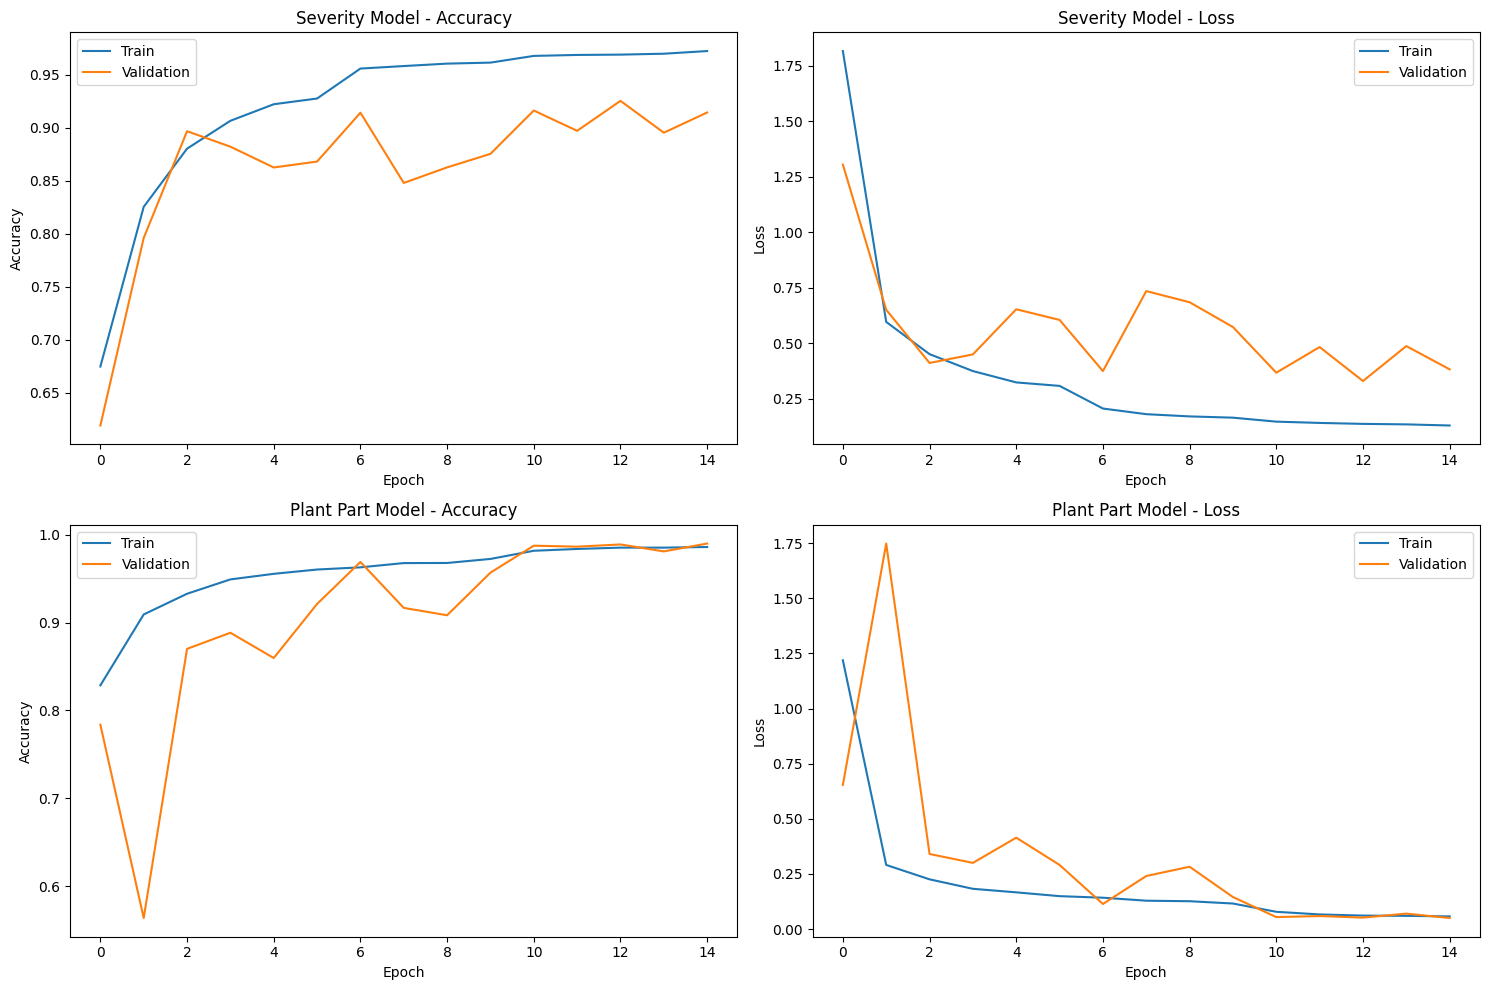

In [56]:
def plot_dual_model_history(severity_hist, part_hist):
    """Plot training history for both models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Severity model plots
    axes[0,0].plot(severity_hist.history['accuracy'], label='Train')
    axes[0,0].plot(severity_hist.history['val_accuracy'], label='Validation')
    axes[0,0].set_title('Severity Model - Accuracy')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    
    axes[0,1].plot(severity_hist.history['loss'], label='Train')
    axes[0,1].plot(severity_hist.history['val_loss'], label='Validation')
    axes[0,1].set_title('Severity Model - Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    
    # Plant part model plots
    axes[1,0].plot(part_hist.history['accuracy'], label='Train')
    axes[1,0].plot(part_hist.history['val_accuracy'], label='Validation')
    axes[1,0].set_title('Plant Part Model - Accuracy')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].legend()
    
    axes[1,1].plot(part_hist.history['loss'], label='Train')
    axes[1,1].plot(part_hist.history['val_loss'], label='Validation')
    axes[1,1].set_title('Plant Part Model - Loss')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

plot_dual_model_history(severity_history, part_history)


In [57]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_severity_model():
    """Evaluate severity detection model"""
    print("\n" + "="*60)
    print("EVALUATING SEVERITY DETECTION MODEL")
    print("="*60)
    
    # Load best model
    best_severity_model = load_model('severity_detection_model.h5')
    
    # Create test generator for severity
    test_severity_gen = SeverityDataGenerator(validation_generator, class_to_severity_map)
    
    # Get predictions
    predictions = []
    true_labels = []
    
    validation_generator.reset()
    for i in range(len(validation_generator)):
        batch_x, batch_y = next(test_severity_gen)
        pred = best_severity_model.predict(batch_x, verbose=0)
        predictions.extend(np.argmax(pred, axis=1))
        true_labels.extend(batch_y)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    print(f"Severity Detection Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=severity_names,
                yticklabels=severity_names)
    plt.title(f'Severity Detection - Confusion Matrix\nAccuracy: {accuracy:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification report
    print("\nSeverity Detection Classification Report:")
    print(classification_report(true_labels, predictions, target_names=severity_names))
    
    return best_severity_model, accuracy




SAFE MODEL EVALUATION
Severity model file exists: True
Plant part model file exists: True

EVALUATING SEVERITY DETECTION MODEL
✅ Model loaded successfully
✅ Test generator created successfully
Starting prediction loop...
Processed batch 1/169
Processed batch 11/169
Processed batch 21/169
Processed batch 31/169
Processed batch 41/169
Processed batch 51/169
Processed batch 61/169
Processed batch 71/169
Processed batch 81/169
Processed batch 91/169
Processed batch 101/169
Processed batch 111/169
Processed batch 121/169
Processed batch 131/169
Processed batch 141/169
Processed batch 151/169
Processed batch 161/169
Severity Detection Accuracy: 0.9252 (92.52%)


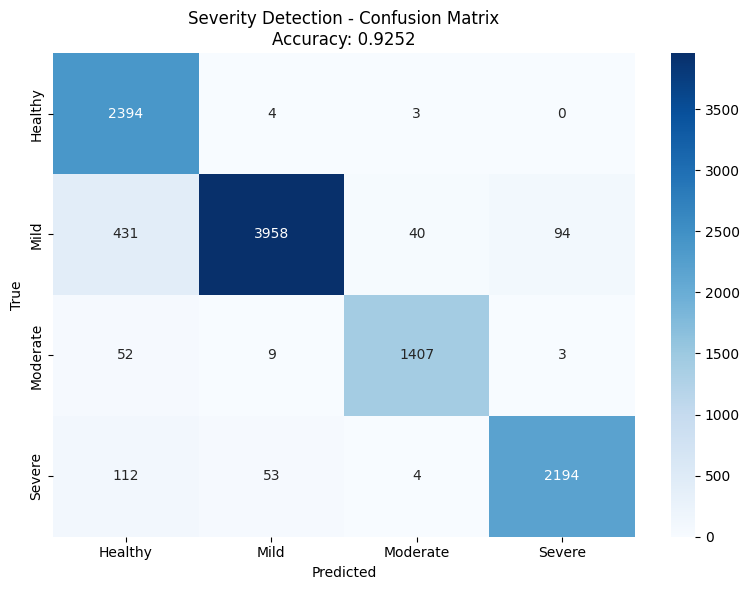


Severity Detection Classification Report:
              precision    recall  f1-score   support

     Healthy       0.80      1.00      0.89      2401
        Mild       0.98      0.88      0.93      4523
    Moderate       0.97      0.96      0.96      1471
      Severe       0.96      0.93      0.94      2363

    accuracy                           0.93     10758
   macro avg       0.93      0.94      0.93     10758
weighted avg       0.93      0.93      0.93     10758


EVALUATING PLANT PART DETECTION MODEL
✅ Model loaded successfully
✅ Test generator created successfully
Starting prediction loop...
Processed batch 1/169
Processed batch 11/169
Processed batch 21/169
Processed batch 31/169
Processed batch 41/169
Processed batch 51/169
Processed batch 61/169
Processed batch 71/169
Processed batch 81/169
Processed batch 91/169
Processed batch 101/169
Processed batch 111/169
Processed batch 121/169
Processed batch 131/169
Processed batch 141/169
Processed batch 151/169
Processed batch 

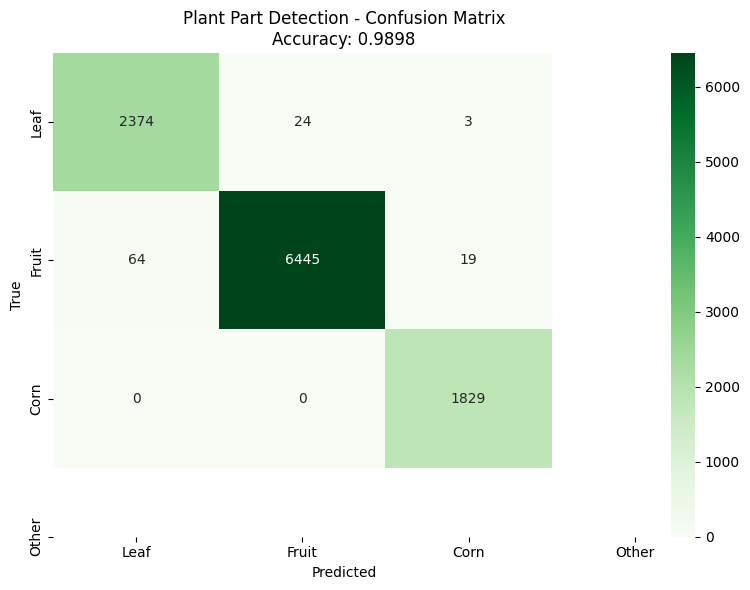


Plant Part Detection Classification Report:
⚠️ Error creating classification report: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

EVALUATION SUMMARY
Severity Model: success
  Accuracy: 92.52%
Plant_Part Model: success
  Accuracy: 98.98%


In [60]:
# EVALUATION FUNCTIONS
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_plant_part_model():
    """Evaluate plant part detection model - CORRECTED VERSION"""
    print("\n" + "="*60)
    print("EVALUATING PLANT PART DETECTION MODEL")
    print("="*60)
    
    try:
        # Load best model
        best_part_model = load_model('plant_part_detection_model.h5')
        print("✅ Model loaded successfully")
    except FileNotFoundError:
        print("❌ Model file 'plant_part_detection_model.h5' not found!")
        print("Make sure the model was saved during training.")
        return None, 0
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, 0
    
    # Check if required variables exist
    if 'validation_generator' not in globals():
        print("❌ validation_generator not found!")
        return None, 0
    
    if 'class_to_part_map' not in globals():
        print("❌ class_to_part_map not found!")
        return None, 0
        
    if 'part_names' not in globals():
        print("❌ part_names not found!")
        return None, 0
    
    # Create test generator for plant parts
    try:
        test_part_gen = PlantPartDataGenerator(validation_generator, class_to_part_map)
        print("✅ Test generator created successfully")
    except Exception as e:
        print(f"❌ Error creating test generator: {e}")
        return None, 0
    
    # Get predictions with error handling
    predictions = []
    true_labels = []
    
    try:
        validation_generator.reset()
        print("Starting prediction loop...")
        
        for i in range(len(test_part_gen)):
            try:
                batch_x, batch_y = test_part_gen[i]  # Use indexing instead of next()
                pred = best_part_model.predict(batch_x, verbose=0)
                predictions.extend(np.argmax(pred, axis=1))
                true_labels.extend(batch_y)
                
                if i % 10 == 0:  # Progress indicator
                    print(f"Processed batch {i+1}/{len(test_part_gen)}")
                    
            except Exception as e:
                print(f"❌ Error processing batch {i}: {e}")
                continue
                
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None, 0
    
    if len(predictions) == 0 or len(true_labels) == 0:
        print("❌ No predictions were made!")
        return None, 0
    
    # Calculate accuracy
    try:
        accuracy = accuracy_score(true_labels, predictions)
        print(f"Plant Part Detection Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    except Exception as e:
        print(f"❌ Error calculating accuracy: {e}")
        return None, 0
    
    # Create confusion matrix
    try:
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                    xticklabels=part_names,
                    yticklabels=part_names)
        plt.title(f'Plant Part Detection - Confusion Matrix\nAccuracy: {accuracy:.4f}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Error creating confusion matrix plot: {e}")
    
    # Classification report
    try:
        print("\nPlant Part Detection Classification Report:")
        report = classification_report(true_labels, predictions, target_names=part_names)
        print(report)
    except Exception as e:
        print(f"⚠️ Error creating classification report: {e}")
    
    return best_part_model, accuracy


def evaluate_severity_model():
    """Evaluate severity detection model - CORRECTED VERSION"""
    print("\n" + "="*60)
    print("EVALUATING SEVERITY DETECTION MODEL")
    print("="*60)
    
    try:
        # Load best model
        best_severity_model = load_model('severity_detection_model.h5')
        print("✅ Model loaded successfully")
    except FileNotFoundError:
        print("❌ Model file 'severity_detection_model.h5' not found!")
        print("Make sure the model was saved during training.")
        return None, 0
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, 0
    
    # Check if required variables exist
    if 'validation_generator' not in globals():
        print("❌ validation_generator not found!")
        return None, 0
    
    if 'class_to_severity_map' not in globals():
        print("❌ class_to_severity_map not found!")
        return None, 0
        
    if 'severity_names' not in globals():
        print("❌ severity_names not found!")
        return None, 0
    
    # Create test generator for severity
    try:
        test_severity_gen = SeverityDataGenerator(validation_generator, class_to_severity_map)
        print("✅ Test generator created successfully")
    except Exception as e:
        print(f"❌ Error creating test generator: {e}")
        return None, 0
    
    # Get predictions with error handling
    predictions = []
    true_labels = []
    
    try:
        validation_generator.reset()
        print("Starting prediction loop...")
        
        for i in range(len(test_severity_gen)):
            try:
                batch_x, batch_y = test_severity_gen[i]  # Use indexing instead of next()
                pred = best_severity_model.predict(batch_x, verbose=0)
                predictions.extend(np.argmax(pred, axis=1))
                true_labels.extend(batch_y)
                
                if i % 10 == 0:  # Progress indicator
                    print(f"Processed batch {i+1}/{len(test_severity_gen)}")
                    
            except Exception as e:
                print(f"❌ Error processing batch {i}: {e}")
                continue
                
    except Exception as e:
        print(f"❌ Error during prediction: {e}")
        return None, 0
    
    if len(predictions) == 0 or len(true_labels) == 0:
        print("❌ No predictions were made!")
        return None, 0
    
    # Calculate accuracy
    try:
        accuracy = accuracy_score(true_labels, predictions)
        print(f"Severity Detection Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    except Exception as e:
        print(f"❌ Error calculating accuracy: {e}")
        return None, 0
    
    # Create confusion matrix
    try:
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=severity_names,
                    yticklabels=severity_names)
        plt.title(f'Severity Detection - Confusion Matrix\nAccuracy: {accuracy:.4f}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Error creating confusion matrix plot: {e}")
    
    # Classification report
    try:
        print("\nSeverity Detection Classification Report:")
        report = classification_report(true_labels, predictions, target_names=severity_names)
        print(report)
    except Exception as e:
        print(f"⚠️ Error creating classification report: {e}")
    
    return best_severity_model, accuracy


# SAFE EVALUATION CALLER
def safe_evaluate_models():
    """Safely evaluate both models with comprehensive error checking"""
    print("\n" + "="*80)
    print("SAFE MODEL EVALUATION")
    print("="*80)
    
    # Check if models exist before evaluation
    import os
    
    severity_model_exists = os.path.exists('severity_detection_model.h5')
    part_model_exists = os.path.exists('plant_part_detection_model.h5')
    
    print(f"Severity model file exists: {severity_model_exists}")
    print(f"Plant part model file exists: {part_model_exists}")
    
    results = {}
    
    # Evaluate severity model
    if severity_model_exists:
        try:
            severity_model_final, severity_accuracy = evaluate_severity_model()
            results['severity'] = {
                'model': severity_model_final,
                'accuracy': severity_accuracy,
                'status': 'success' if severity_model_final is not None else 'failed'
            }
        except Exception as e:
            print(f"❌ Severity model evaluation failed: {e}")
            results['severity'] = {'status': 'failed', 'error': str(e)}
    else:
        print("⚠️ Severity model file not found, skipping evaluation")
        results['severity'] = {'status': 'skipped', 'reason': 'file not found'}
    
    # Evaluate plant part model
    if part_model_exists:
        try:
            part_model_final, part_accuracy = evaluate_plant_part_model()
            results['plant_part'] = {
                'model': part_model_final,
                'accuracy': part_accuracy,
                'status': 'success' if part_model_final is not None else 'failed'
            }
        except Exception as e:
            print(f"❌ Plant part model evaluation failed: {e}")
            results['plant_part'] = {'status': 'failed', 'error': str(e)}
    else:
        print("⚠️ Plant part model file not found, skipping evaluation")
        results['plant_part'] = {'status': 'skipped', 'reason': 'file not found'}
    
    # Summary
    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)
    
    for model_type, result in results.items():
        print(f"{model_type.title()} Model: {result['status']}")
        if result['status'] == 'success' and 'accuracy' in result:
            print(f"  Accuracy: {result['accuracy']*100:.2f}%")
        elif result['status'] == 'failed' and 'error' in result:
            print(f"  Error: {result['error']}")
        elif result['status'] == 'skipped':
            print(f"  Reason: {result['reason']}")
    
    return results

# Run the safe evaluation
if __name__ == "__main__":
    results = safe_evaluate_models()


SAFE MODEL EVALUATION
Severity model file exists: True
Plant part model file exists: True

EVALUATING SEVERITY DETECTION MODEL
✅ Model loaded successfully
✅ Test generator created successfully
Starting prediction loop...
Processed batch 1/169
Processed batch 11/169
Processed batch 21/169
Processed batch 31/169
Processed batch 41/169
Processed batch 51/169
Processed batch 61/169
Processed batch 71/169
Processed batch 81/169
Processed batch 91/169
Processed batch 101/169
Processed batch 111/169
Processed batch 121/169
Processed batch 131/169
Processed batch 141/169
Processed batch 151/169
Processed batch 161/169
Severity Detection Accuracy: 0.9252 (92.52%)


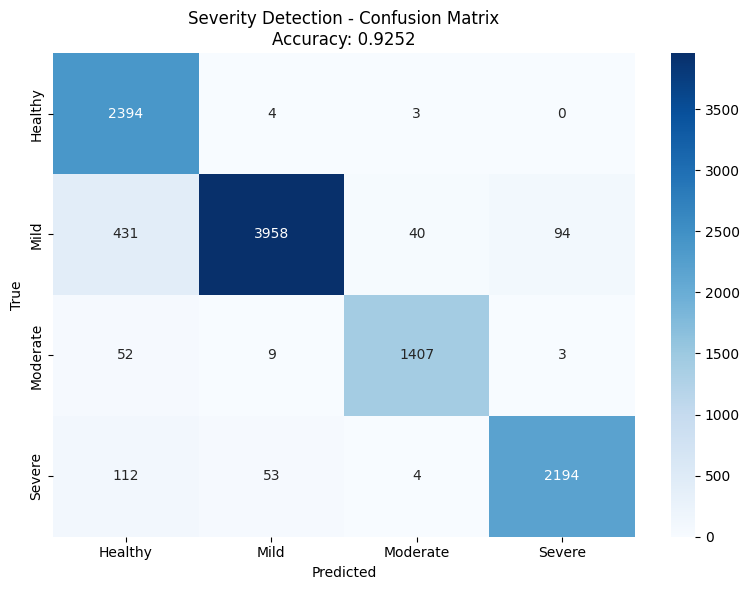


Severity Detection Classification Report:
              precision    recall  f1-score   support

     Healthy       0.80      1.00      0.89      2401
        Mild       0.98      0.88      0.93      4523
    Moderate       0.97      0.96      0.96      1471
      Severe       0.96      0.93      0.94      2363

    accuracy                           0.93     10758
   macro avg       0.93      0.94      0.93     10758
weighted avg       0.93      0.93      0.93     10758


EVALUATING PLANT PART DETECTION MODEL
✅ Model loaded successfully
✅ Test generator created successfully
Starting prediction loop...
Processed batch 1/169
Processed batch 11/169
Processed batch 21/169
Processed batch 31/169
Processed batch 41/169
Processed batch 51/169
Processed batch 61/169
Processed batch 71/169
Processed batch 81/169
Processed batch 91/169
Processed batch 101/169
Processed batch 111/169
Processed batch 121/169
Processed batch 131/169
Processed batch 141/169
Processed batch 151/169
Processed batch 

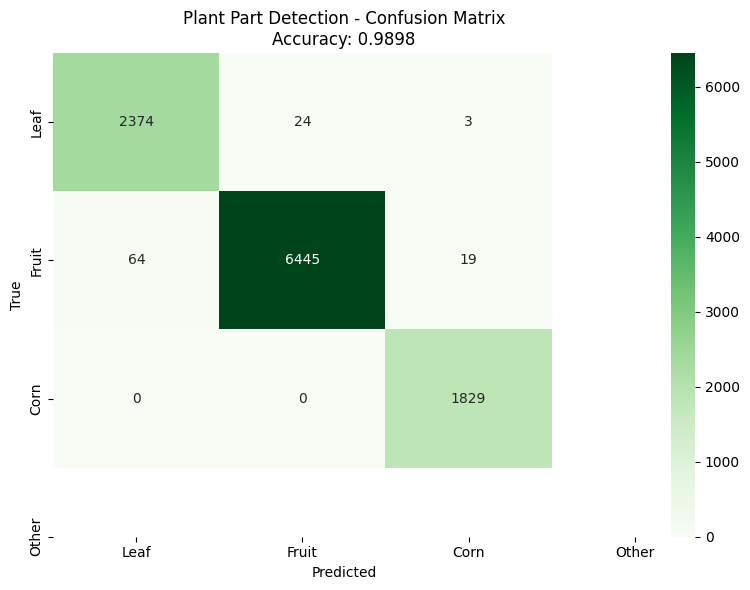


Plant Part Detection Classification Report:
⚠️ Error creating classification report: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

EVALUATION SUMMARY
Severity Model: success
  Accuracy: 92.52%
Plant_Part Model: success
  Accuracy: 98.98%

SAVING ALL MODELS


In [64]:
# Run your safe evaluation function
results = safe_evaluate_models()

# Extract accuracy values from results
if results['severity']['status'] == 'success':
    severity_accuracy = results['severity']['accuracy']
else:
    severity_accuracy = 0  # fallback value

if results['plant_part']['status'] == 'success':
    part_accuracy = results['plant_part']['accuracy']
else:
    part_accuracy = 0  # fallback value

# Now save with accuracy in filename
print("\n" + "="*60)
print("SAVING ALL MODELS")
print("="*60)
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save models with descriptive names
severity_model_name = f"crop_severity_model_{severity_accuracy*100:.1f}percent_{timestamp}.h5"
part_model_name = f"crop_part_model_{part_accuracy*100:.1f}percent_{timestamp}.h5"

In [67]:

def predict_all_three(image_path, disease_model, severity_model, part_model):
    """
    Use all three models to get comprehensive plant analysis
    """
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Get predictions from all models
    disease_pred = disease_model.predict(img_array, verbose=0)
    severity_pred = severity_model.predict(img_array, verbose=0)
    part_pred = part_model.predict(img_array, verbose=0)
    
    # Get class names
    disease_class = classes_to_keep[np.argmax(disease_pred)]
    severity_class = severity_names[np.argmax(severity_pred)]
    part_class = part_names[np.argmax(part_pred)]
    
    # Confidence scores
    disease_conf = np.max(disease_pred) * 100
    severity_conf = np.max(severity_pred) * 100
    part_conf = np.max(part_pred) * 100
    
    print(f"🌱 COMPREHENSIVE PLANT ANALYSIS:")
    print(f"   Disease: {disease_class} ({disease_conf:.1f}% confidence)")
    print(f"   Severity: {severity_class} ({severity_conf:.1f}% confidence)")
    print(f"   Plant Part: {part_class} ({part_conf:.1f}% confidence)")
    
    return {
        'disease': disease_class,
        'severity': severity_class, 
        'plant_part': part_class,
        'confidences': {
            'disease': disease_conf,
            'severity': severity_conf,
            'plant_part': part_conf
        }
    }
